# Customer Churn Reduction  - Random forest

Finding wether a customer will churn out or not. Random forest was use.

In [1]:
# importing requried libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas_ml import ConfusionMatrix

%matplotlib inline



In [2]:
# Reading train data
inputTrain = pd.read_csv("Train_data.csv")
# Reading test data
inputTest = pd.read_csv("Test_data.csv")

In [3]:
# change column names for ease of use and display first 5 rows
inputTrain.columns = inputTrain.columns.str.lower().str.replace(' ', '_')
inputTest.columns = inputTest.columns.str.lower().str.replace(' ', '_')


In [4]:
#dimensions 
inputTrain.shape
inputTest.shape


(1667, 21)

In [5]:
# calculating quick summary statstic for continous predictors
inputTrain.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [6]:
#removing variables which not helpfull in churn reduction. Using these variables dosn't make sense.
#for training data
inputTrain = inputTrain.drop(['state','area_code','phone_number'], axis = 1)
inputTest = inputTest.drop(['state','area_code','phone_number'], axis = 1)

In [7]:
# sanity check
print(inputTrain.shape)
print(inputTest.shape)

(3333, 18)
(1667, 18)


In [8]:
print("Train dataset",inputTrain.churn.value_counts())
print("Test data", inputTest.churn.value_counts())

Train dataset  False.    2850
 True.      483
Name: churn, dtype: int64
Test data  False.    1443
 True.      224
Name: churn, dtype: int64


In [9]:
# encoding categorical and target variable to binary
# converting international_plan,voice_mail_plan and churn

le = LabelEncoder()

inputTrain.international_plan = le.fit_transform(inputTrain.international_plan)
inputTrain.voice_mail_plan = le.fit_transform(inputTrain.voice_mail_plan)
inputTrain.churn = le.fit_transform(inputTrain.churn)

inputTest.international_plan = le.fit_transform(inputTest.international_plan)
inputTest.voice_mail_plan = le.fit_transform(inputTest.voice_mail_plan)
inputTest.churn = le.fit_transform(inputTest.churn)


In [10]:
# selecting predictors
train_feature_space = inputTrain.iloc[:,inputTrain.columns != 'churn']
# selecting target class
target_class = inputTrain.iloc[:,inputTrain.columns == 'churn']



In [11]:
# creating training and validation set
training_set, validation_set, train_taget, validation_target = train_test_split(train_feature_space,
                                                                    target_class,
                                                                    test_size = 0.30, 
                                                                    random_state = 12345)

# Cleaning test sets to avoid future warning messages
train_taget = train_taget.values.ravel() 
validation_target = validation_target.values.ravel() 


## Random forest Implementation 

In [12]:
# using random forest classifier. setting a random state
fit_randomForest = RandomForestClassifier(random_state=12345)

### Hyperparameters Optimization¶

Utilizing the RandomizedSearchCV functionality, we create a dictionary with parameters we are looking to optimize to create the best model for our data.

In [13]:
np.random.seed(12)
start = time.time()

# selecting best max_depth, maximum features, split criterion and number of trees
param_dist = {'max_depth': [2,4,6,8,10],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2',None],
              "criterion": ["gini", "entropy"],
              "n_estimators" : [100 ,200 ,300 ,400 ,500]
             }
cv_randomForest = RandomizedSearchCV(fit_randomForest, cv = 10,
                     param_distributions = param_dist, 
                     n_iter = 10)

cv_randomForest.fit(training_set, train_taget)
print('Best Parameters using random search: \n', 
      cv_randomForest.best_params_)
end = time.time()
print('Time taken in random search: {0: .2f}'.format(end - start))

Best Parameters using random search: 
 {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
Time taken in random search:  214.92


In [39]:
# Set best parameters given by random search 
fit_randomForest.set_params(criterion = 'gini',
                  max_features = 'auto', 
                  max_depth = 10,
                  n_estimators = 100
                )


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [40]:
fit_randomForest.fit(training_set, train_taget)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [16]:
importances_rf = fit_randomForest.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

In [17]:
def variable_importance_plot(importance, indices,training_set):
    
    index = np.arange(len(training_set.columns))
   
    
    importance_desc = sorted(importance) 
    feature_space = []
    for i in range(16, -1, -1):
        feature_space.append(training_set.columns[indices[i]])

    fig, ax = plt.subplots(figsize=(14, 14))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Random Forest Model for Customer churn')
    plt.barh(index, 
             importance_desc,
             align="center", 
             color = '#875FDB')
    plt.yticks(index, 
               feature_space)
    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in gini')
    plt.ylabel('Feature')
    plt.savefig('VarImp.png')
    #savefig('VarImp.pdf')
    plt.show()
   
    
    plt.close()

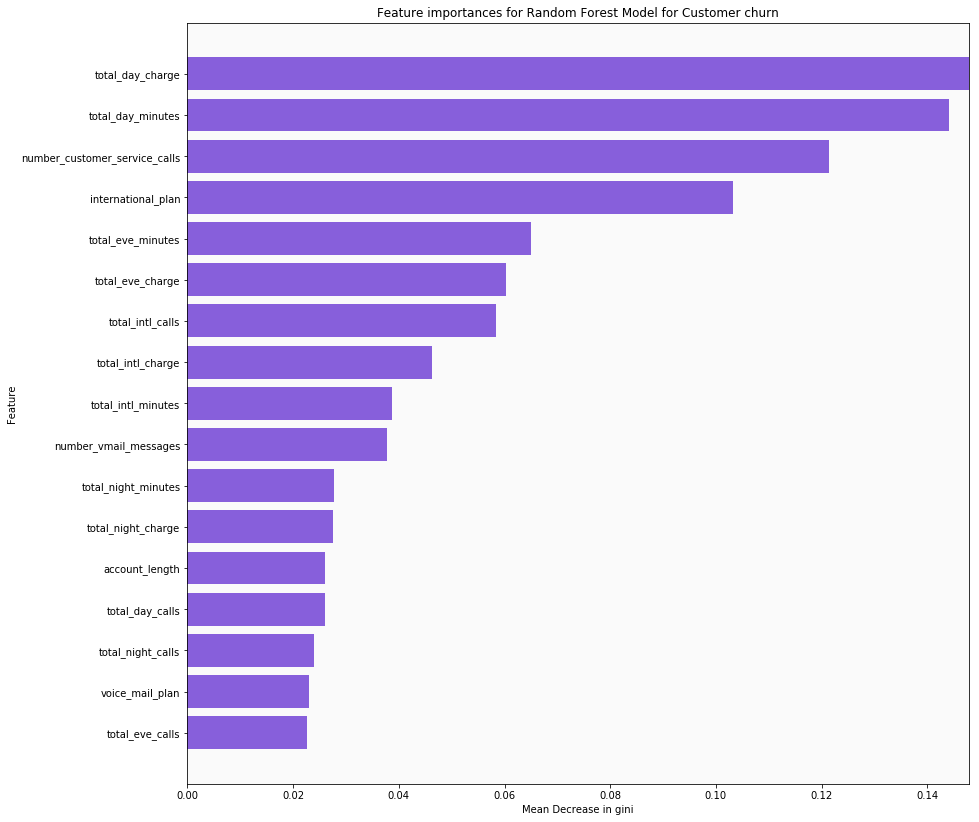

In [18]:
variable_importance_plot(importances_rf, indices_rf,training_set)


## perfoming Cross validation

In [19]:
# function to perform cross validation
def cross_val_metrics(fit, training_set, train_taget,print_results = True):
   
    n = KFold(n_splits=10)
    scores = cross_val_score(fit, 
                         training_set, 
                         train_taget, 
                         cv = n)
    if print_results:
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
              .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [20]:
cross_val_metrics(fit_randomForest, training_set, 
                  train_taget, 
                  print_results = True)

Accuracy:  0.955 (+/-  0.009)


## prediction and performance measure on validation set

In [41]:
predictions_randomForest_validation = fit_randomForest.predict(validation_set)

validation_crosstb = pd.crosstab(index = validation_target,
                           columns = predictions_randomForest_validation)
validation_crosstb = validation_crosstb.rename(columns= {0: 'False', 1: 'True'})
validation_crosstb.index = ['False', 'True']
validation_crosstb.columns.name = 'n = 1000'


In [42]:
# confusion matrix of validation set
validation_crosstb

n = 1000,False,True
False,837,10
True,45,108


In [23]:
# mean accuracy on validation set
accuracy_randomForest_val = fit_randomForest.score(validation_set, validation_target)
print(' Mean accuracy on validation set',accuracy_randomForest_val)

 Mean accuracy on validation set 0.941


In [24]:
# calculating test error rate on validation set
test_error_rate = 1 - accuracy_randomForest_val
print(' Test error rate on validation set',test_error_rate)

 Test error rate on validation set 0.059


In [25]:
#classification report on validation set
target_names =[0,1]

validation_report = classification_report(predictions_randomForest_validation, validation_target,  target_names )
print(validation_report)

             precision    recall  f1-score   support

          0       0.99      0.95      0.97       882
          1       0.69      0.90      0.78       118

avg / total       0.95      0.94      0.94      1000



## prediction and performance measure on test set

In [43]:
#selecting predictors
test_set = inputTest.iloc[:,inputTest.columns != 'churn']
# selecting target class
test_target = inputTest.iloc[:,inputTest.columns == 'churn']

test_prediction = fit_randomForest.predict(test_set)

In [44]:
#performing prediction on test set
test_prediction = fit_randomForest.predict(test_set)

In [45]:
# creating confusion matrix of test set
confusion_matrix(test_target,test_prediction)

array([[1439,    4],
       [  70,  154]], dtype=int64)

In [46]:
test_rf_crosstb = pd.crosstab(index = test_target.churn,
                           columns = test_prediction)
test_rf_crosstb = test_rf_crosstb.rename(columns= {0: 'False', 1: 'True'})
test_rf_crosstb.index = ['False', 'True']
test_rf_crosstb.columns.name = 'n = 1667'

In [47]:
test_rf_crosstb

n = 1667,False,True
False,1439,4
True,70,154


In [31]:
# mean accuracy on test set
accuracy_randomForest_test = fit_randomForest.score(test_set, test_target.churn)
print(' Mean accuracy on test set',accuracy_randomForest_test)

 Mean accuracy on test set 0.953809238152


In [32]:
# calculating test error rate on test set
test_error_rate_testset = 1 - accuracy_randomForest_test
print(' Test error rate on test set',test_error_rate)

 Test error rate on test set 0.059


In [33]:
#classification report on test set
target_names =[0,1]

test_report = classification_report(test_prediction, test_target.churn,  target_names )
print(test_report)

             precision    recall  f1-score   support

          0       0.99      0.96      0.97      1500
          1       0.70      0.94      0.80       167

avg / total       0.96      0.95      0.96      1667



In [35]:
cm = ConfusionMatrix(test_target.churn, test_prediction)

In [38]:
cm

Predicted  False  True  __all__
Actual                         
False       1433    10     1443
True          67   157      224
__all__     1500   167     1667

In [48]:
cm.print_stats()

population: 1667
P: 224
N: 1443
PositiveTest: 167
NegativeTest: 1500
TP: 157
TN: 1433
FP: 10
FN: 67
TPR: 0.700892857143
TNR: 0.99306999307
PPV: 0.940119760479
NPV: 0.955333333333
FPR: 0.00693000693001
FDR: 0.059880239521
FNR: 0.299107142857
ACC: 0.953809238152
F1_score: 0.803069053708
MCC: 0.788296379044
informedness: 0.693962850213
markedness: 0.895453093812
prevalence: 0.134373125375
LRP: 101.138839286
LRN: 0.301194422291
DOR: 335.792537313
FOR: 0.0446666666667


In [69]:
# Model input and output
test_set.to_csv('inputRandomForestPython.csv', encoding = 'utf-8', index = False)
pd.DataFrame(train_taget).to_csv('targetInputRandomForestPython.csv', index = False)
pd.DataFrame(test_prediction, columns=['predictions']).to_csv('outputRandomForestPython.csv')
